## MTH9893 Time Series Analysis
### Homework 5
### Group07: Xinlu Xiao & Gaoxian Song

### Problem1

To prove that $\upsilon_{t} = Y_{t} - E[X_{t}|Y_{1:t-1}]$ are mutually independent for different $t$, we know that the $\upsilon_{t}$ are jointly Gaussian, if we can prove that they are uncorrelated, then it can be proved that they are mutually independent:

Consider an $s<t$:

First recall the "Tower Property":

If $H \subset G$, then $E[E[Y|H]|G] = E[Y|H] $ and $E[E[Y|G]|H] = E[Y|H]$

We know that 

$$ E[\upsilon_t] = E[Y_t - E[X_t|Y_{1:t-1}]] = E[Y_t] - E[E[X_t|Y_{1:t-1}]] = E[X_t+\eta_t]-E[X_t] = 0$$

We compute the covariance between two innovations:

\begin{align}
Cov(\upsilon_{t},\upsilon_{s})
& = E[\upsilon_{t} \upsilon_{s}] - E[\upsilon_{t}]E[\upsilon_{s}]\\
& = E[\upsilon_{t} \upsilon_{s}] \\
& = E[E[\upsilon_{t} \upsilon_{s}|Y_{1:s}]] \\
& = E[E[\upsilon_{t}|Y_{1:s}]\upsilon_{s}] \\
& = E[E[Y_{t}-E[X_{t}|Y_{1:t-1}]|Y_{1:s}]\upsilon_{s}]\\
& = E[(E[Y_{t}|Y_{1:s}]-E[E[X_t|Y_{1:t-1}]|Y_{1:s}])\upsilon_{s}]\\
& = E[(E[X_t + \eta_{t}|Y_{1:s}]-E[X_t|Y_{1:s}])\upsilon_s]\\
& = E[(E[X_t|Y_{1:s}]-E[X_t|Y_{1:s}])\upsilon_s] \\
& = 0
\end{align}


They are uncorrelated. So they are mutually independent.


### Problem2

#### Intall command: " $ easy_install pykalman"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

%matplotlib inline

In [2]:
# read data
SPX = pd.read_excel('data.xlsx', skiprows = 1, parse_cols = 'A:B').rename(columns = {'PX_LAST':'adj_price'})
AAPL = pd.read_excel('data.xlsx', skiprows = 1, parse_cols = 'D:E').rename(columns = {'PX_LAST': 'adj_price'})

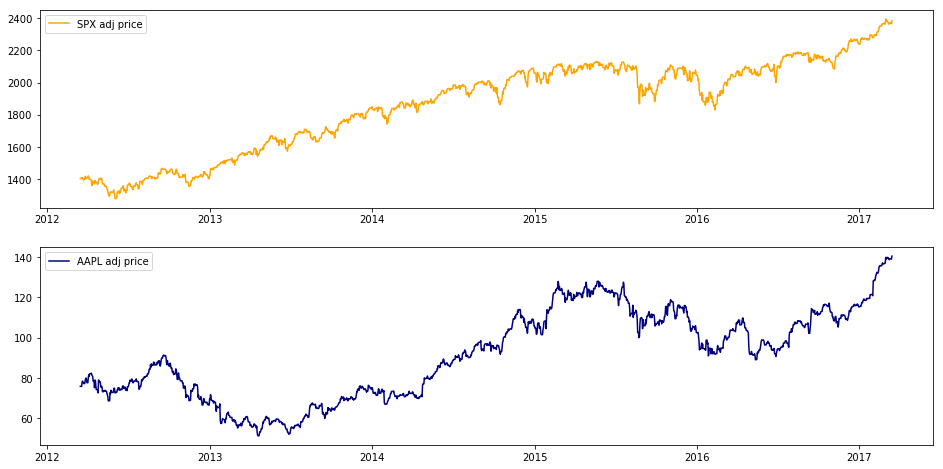

In [3]:
plt.rcParams['figure.figsize'] = (16,8)
plt.subplot(2,1,1)
plt.plot(SPX['Date'], SPX['adj_price'], color = 'orange',label = 'SPX adj price')
plt.legend()
plt.subplot(2,1,2)
plt.plot(AAPL['Date'], AAPL['adj_price'],color = 'navy', label = 'AAPL adj price')
plt.legend()

In [4]:
# get the return
spx_return = np.log(SPX['adj_price']).diff().dropna()
aapl_return = np.log(AAPL['adj_price']).diff().dropna()

In [5]:
# run linear model with windows = 63
model = pd.ols(y = aapl_return, x = spx_return, window_type = 'rolling', window = 63)

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/regression.html
  from ipykernel import kernelapp as app


In [6]:
# get the coefficients
coeff = model.beta
beta = coeff['x'].reset_index()['x']
alpha = coeff['intercept'].reset_index()['intercept']

In [7]:
spx_return = spx_return.drop(spx_return.index[0:62]).reset_index()['adj_price']
aapl_return = aapl_return.drop(aapl_return.index[0:62]).reset_index()['adj_price']

In [8]:
Xt = alpha
Yt = []
for i in range(len(Xt)):
    y = aapl_return[i] - beta[i]*spx_return[i]
    Yt.append(y)
    
# convert to numpy array
Xt = np.array(alpha)
Yt = np.array(Yt)

In [9]:
# create kalman filter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  transition_offsets=[0],
                  observation_offsets=[0],
                  initial_state_mean=0,
                  transition_covariance=[np.var(Xt[1:]-Xt[:-1])],
                  observation_covariance=[np.var(Yt-Xt)],
                  initial_state_covariance=[np.var(Xt)], 
                  n_dim_obs = 1,
                  random_state = 0)

# estimate parameters
kf = kf.em(Yt)

In [10]:
(filtered_state_means, filtered_state_covariances) = kf.filter(Yt)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(Yt)

In [11]:
# create dataframe
df_filtered = pd.DataFrame(filtered_state_means, columns = ['filtered']).reset_index()['filtered']
df_observed = pd.DataFrame(Xt, columns = ['observed']).reset_index()['observed']
df_smoothed = pd.DataFrame(smoothed_state_means, columns = ['smoothed']).reset_index()['smoothed']

df = pd.concat([df_filtered,df_observed,df_smoothed], axis = 1)

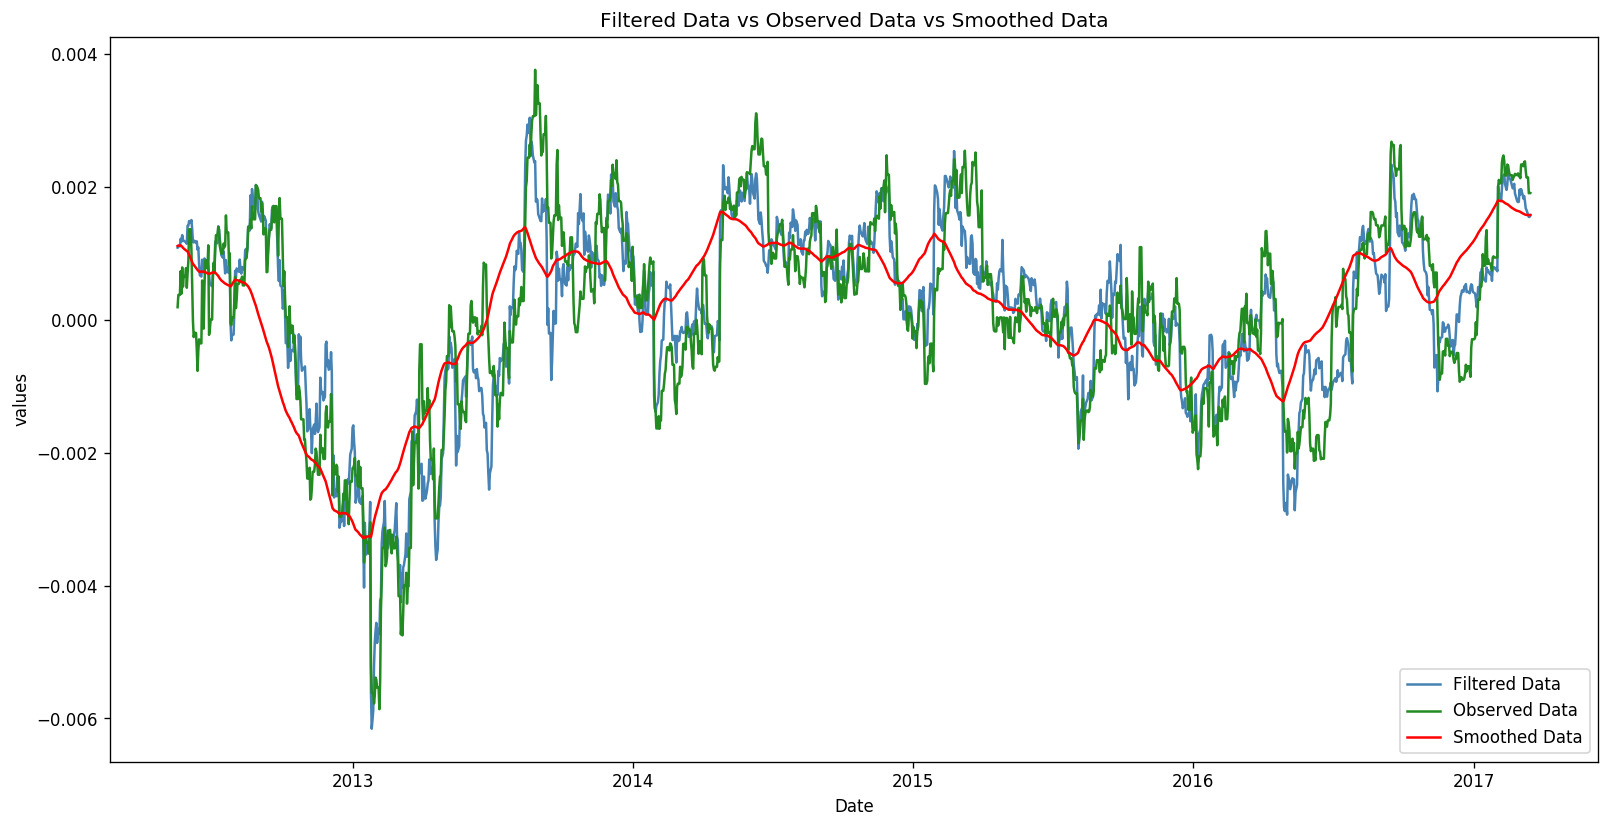

In [12]:
plt.figure(figsize=(16,8),dpi=120)
plt.plot(SPX['Date'][63:],df_filtered, linestyle = '-', color = 'steelblue', label = 'Filtered Data')
plt.plot(SPX['Date'][63:],df_observed, linestyle = '-', color = 'forestgreen', label = 'Observed Data')
plt.plot(SPX['Date'][63:],df_smoothed, linestyle = '-', color = 'red', label = 'Smoothed Data')
plt.title('Filtered Data vs Observed Data vs Smoothed Data')
plt.xlabel('Date')
plt.ylabel('values')
plt.legend(loc = 'lower right')

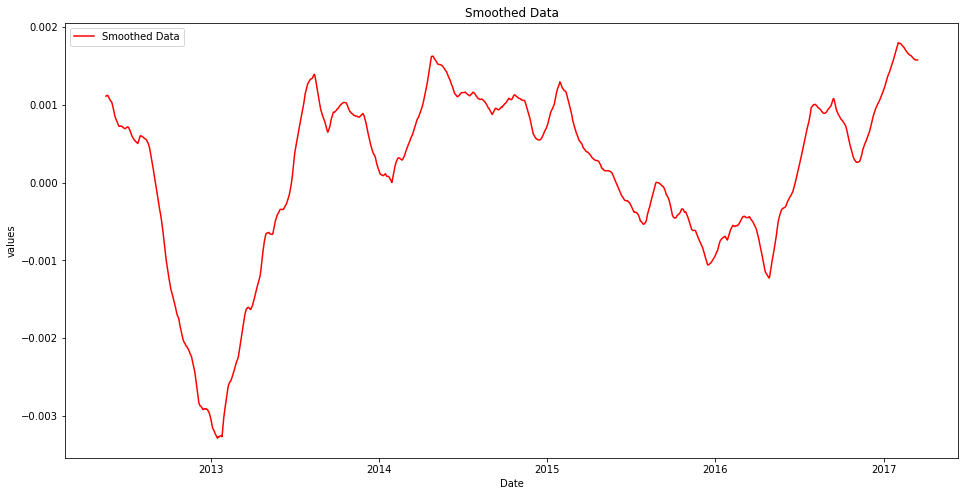

In [13]:
plt.plot(SPX['Date'][63:],df_smoothed, linestyle = '-', color = 'red', label = 'Smoothed Data')
plt.title('Smoothed Data')
plt.xlabel('Date')
plt.ylabel('values')
plt.legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D7AA613AC8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002D7AAB81DD8>]], dtype=object)

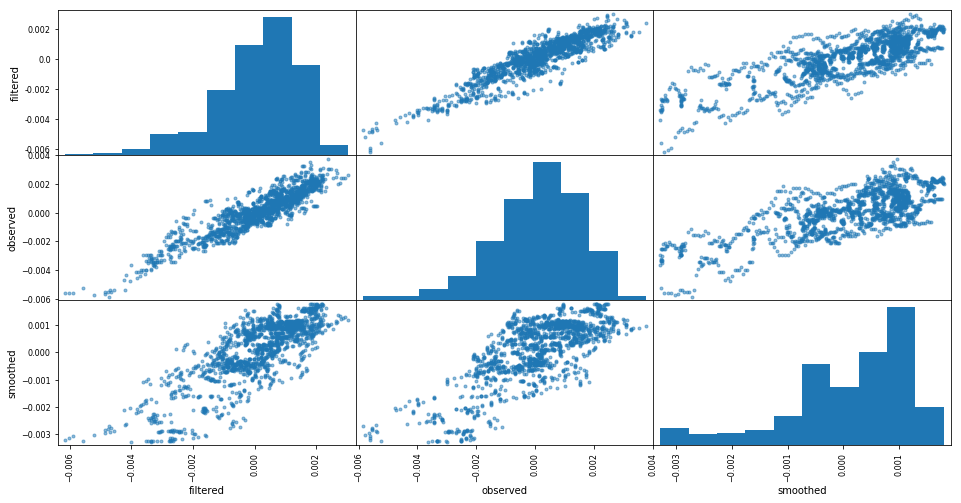

In [14]:
# create scatter plot
pd.tools.plotting.scatter_matrix(df)

In [16]:
# evaluate predictive power
diff=[]
predictdiff=[]
mean,cov=kf.filter(Yt[:10])
for i in range(10,len(alpha)):
    diff.append(abs(alpha[i]-Yt[i])) # get the difference
    next_m,next_c=kf.filter_update(mean[-1],cov[-1],Yt[i])
    mean=next_m
    cov=next_c
    predictdiff.append(abs(alpha[i]-mean[-1]))# get the difference btween prediction of kalman and alpha
print("Absolute error mean between observation and alpha: ",np.mean(diff))
print("Absolute error mean between kalman filter prediction and alpha:",np.mean(predictdiff))
print("The ratio of kalman prediction and observation: ",np.mean(predictdiff)/np.mean(diff))

Absolute error mean between observation and alpha:  0.00673270463947
Absolute error mean between kalman filter prediction and alpha: 0.000484129363884
The ratio of kalman prediction and observation:  0.0719071145711


Based on the above analysis, the prediction error of Kalman Filter is smaller than observation error. It is predictive.